In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## Original Test set import

In [3]:
df00 = pd.read_parquet('../data/raw/test.parquet')

# Metrics

In [4]:
def calculate_global_metric(df0, df1, thresholds=[6], model_name="Unknown"):
    """
    Calculate global AUC, Accuracy, Precision, Recall, F1-score, and plot ROC curves for multiple thresholds.
    ** For parquet format **
    
    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    thresholds (list): List of thresholds for distinguishing active/inactive pIC50, default is [6], max 3 thresholds
    model_name (str): Model name for chart titles and labels, default is "Unknown"
    
    Returns:
    dict: Dictionary containing AUC, Accuracy, Precision, Recall, F1-score for each threshold
    """
    # Ensure thresholds is a list and limit to max 3
    if not isinstance(thresholds, list):
        thresholds = [thresholds]
    thresholds = thresholds[:3]  # Limit to maximum 3 thresholds

    # Load data and ensure no index issues
    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)

    # Ensure column name format is correct
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    # Merge by 'smiles' to ensure data alignment
    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    # Get all target columns
    target_columns = [col for col in df.columns if col not in ["smiles"]]

    # Extract true and predicted values
    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    # Generate mask, only compute known data (non-zero)
    known_mask = (true_pIC50 != 0)
    true_pIC50 = true_pIC50[known_mask]  # True pIC50 values
    pred_pIC50 = pred_pIC50[known_mask]  # Predicted pIC50 values

    # Initialize result dictionary
    results = {}

    # Plot setup for ROC curves
    plt.figure(figsize=(8, 6))

    # Iterate over each threshold
    for threshold in thresholds:
        # Calculate true labels (1: active, 0: inactive)
        y_true = (true_pIC50 > threshold).astype(int)
        y_pred = pred_pIC50  # Predicted scores (for ROC calculation)

        # Calculate ROC and AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        global_auc = auc(fpr, tpr)

        # Plot ROC curve for this threshold
        plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {global_auc:.4f})')

        # Calculate classification metrics (convert predicted values to 0/1)
        y_pred_binary = (y_pred > threshold).astype(int)
        
        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        conf_matrix = confusion_matrix(y_true, y_pred_binary)

        # Store results for this threshold
        results[threshold] = {
            "AUC": global_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Confusion Matrix": conf_matrix
        }

        # Output results for this threshold
        print(f"\nResults for Threshold = {threshold} ({model_name}):")
        print(f"Global AUC: {global_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Global ROC Curves ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

# Example usage:
# results = calculate_global_metric_parq(df0, df1, thresholds=[5, 6, 7], model_name="MyModel")

In [5]:
def calculate_global_regression_metrics(df0, df1, model_name="Unknown"):
    """
    Calculate global regression metrics (MSE, RMSE, MAE, R²), including global MSE (unmasked) and masked MSE,
    and plot a scatter plot of true vs predicted values with a 45-degree diagonal line through the origin.
    Suitable for Parquet format regression tasks, excluding pIC50 values of 0 for masked metrics.

    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    model_name (str): Model name for chart titles and labels, default is "Unknown"

    Returns:
    dict: Dictionary containing global MSE, masked MSE, RMSE, MAE, and R²
    """
    # Load data and ensure no index issues
    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)

    # Ensure column name format is correct (assuming target columns are integers)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    # Merge by 'smiles' to ensure data alignment
    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    # Get all target columns
    target_columns = [col for col in df.columns if col not in ["smiles"]]

    # Extract true and predicted values
    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    # Calculate global MSE (unmasked, including all values)
    global_mse = mean_squared_error(true_pIC50.flatten(), pred_pIC50.flatten())

    # Generate mask, only compute known data (non-zero) for masked metrics
    known_mask = (true_pIC50 != 0)
    y_true = true_pIC50[known_mask]  # True pIC50 values (masked)
    y_pred = pred_pIC50[known_mask]  # Predicted pIC50 values (masked)

    # Calculate regression metrics for masked data
    masked_mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(masked_mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Plot scatter plot with a 45-degree diagonal line through the origin
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=10, label=f'{model_name} ')
    
    # Determine the range for the axes to ensure symmetry and include the origin
    min_val = min(y_true.min(), y_pred.min(), 0)  # Include 0 and go lower if needed
    max_val = max(y_true.max(), y_pred.max())     # Maximum value for symmetry
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')  # 45-degree line
    
    # Set equal aspect ratio and symmetric limits
    plt.axis('square')  # Ensure the plot is square for a true 45-degree angle
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    plt.xlabel('True pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title(f'Global True vs Predicted pIC50 ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot histograms
    plt.hist(y_true, bins=50, alpha=0.7, label="True pIC50")
    plt.hist(y_pred, bins=50, alpha=0.7, label="Predicted pIC50")
    plt.legend()
    plt.show()

    # Output results
    print("Mean of true values:", y_true.mean())
    print("Mean of predicted values:", y_pred.mean())
    print(f"Global Metrics ({model_name}):")
    print(f"Global MSE (unmasked): {global_mse:.6f}")
    print(f"Masked MSE (excluding zeros): {masked_mse:.6f}")
    print(f"RMSE (masked): {rmse:.4f}")
    print(f"MAE (masked): {mae:.4f}")

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "RMSE": rmse,
        "MAE": mae
    }

# Example usage:
# results = calculate_global_regression_metrics2(df0, df1, model_name="MyModel")

# Model Evaluations

## 1. MolE (lr = 1e-05)

In [6]:
df1 = pd.read_parquet('../data/results/predictions_MolE_lr_1e-05.parquet')


Results for Threshold = 5 (MolE(lr = 1e-05)):
Global AUC: 0.6376
Accuracy: 0.4498
Precision: 0.9254
Recall: 0.3143
F1-score: 0.4692
Confusion Matrix:
[[27883  2646]
 [71613 32824]]

Results for Threshold = 6 (MolE(lr = 1e-05)):
Global AUC: 0.6508
Accuracy: 0.6349
Precision: 0.8601
Recall: 0.3082
F1-score: 0.4538
Confusion Matrix:
[[65217  3329]
 [45949 20471]]

Results for Threshold = 7 (MolE(lr = 1e-05)):
Global AUC: 0.6595
Accuracy: 0.7755
Precision: 0.7629
Recall: 0.2533
F1-score: 0.3803
Confusion Matrix:
[[95366  2890]
 [27413  9297]]


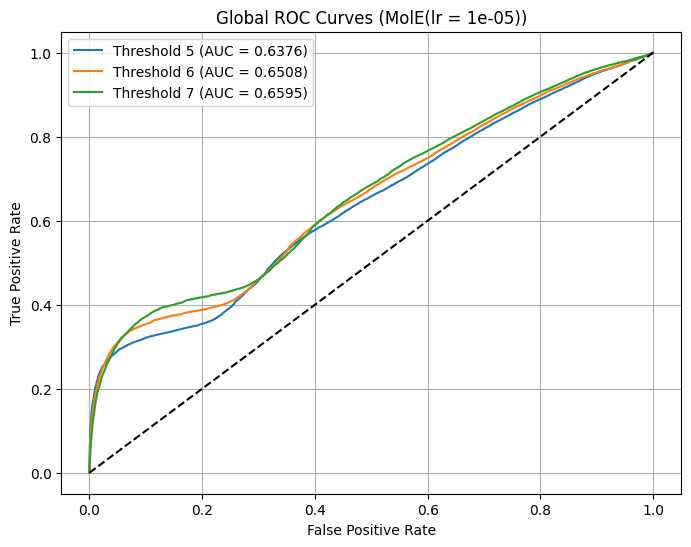

In [18]:
metrics = calculate_global_metric(df00, df1, thresholds=[5,6,7], model_name="MolE(lr = 1e-05)")

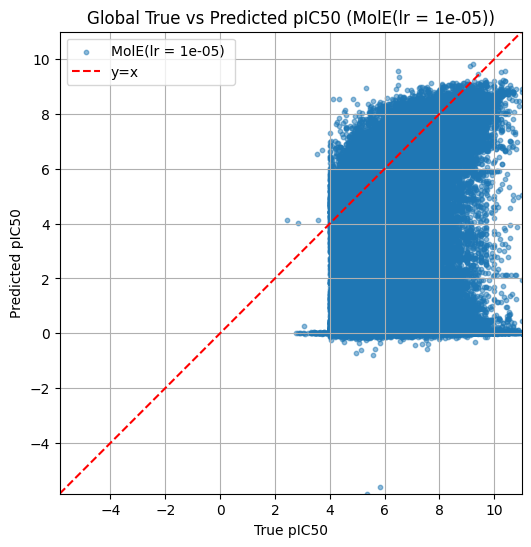

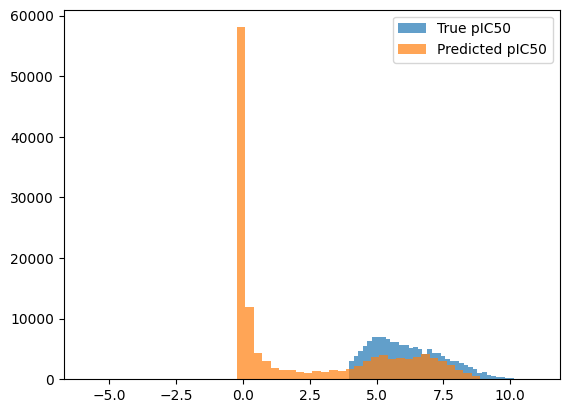

Mean of true values: 6.171844022755179
Mean of predicted values: 2.3321061078525056
Global Metrics (MolE(lr = 1e-05)):
Global MSE (unmasked): 0.007114
Masked MSE (excluding zeros): 22.568429
RMSE (masked): 4.7506
MAE (masked): 3.9883


In [7]:
results = calculate_global_regression_metrics(df00, df1, model_name="MolE(lr = 1e-05)")

## 2. MolE (lr = 1e-04)

In [8]:
df2 =  pd.read_parquet('../data/results/predictions_MolE_lr_1e-04.parquet')


Results for Threshold = 5 (MolE(lr = 1e-04)):
Global AUC: 0.6349
Accuracy: 0.4673
Precision: 0.9403
Recall: 0.3327
F1-score: 0.4915
Confusion Matrix:
[[28324  2205]
 [69689 34748]]

Results for Threshold = 6 (MolE(lr = 1e-04)):
Global AUC: 0.6511
Accuracy: 0.6439
Precision: 0.8871
Recall: 0.3167
F1-score: 0.4667
Confusion Matrix:
[[65868  2678]
 [45388 21032]]

Results for Threshold = 7 (MolE(lr = 1e-04)):
Global AUC: 0.6629
Accuracy: 0.7745
Precision: 0.8241
Recall: 0.2175
F1-score: 0.3442
Confusion Matrix:
[[96552  1704]
 [28726  7984]]


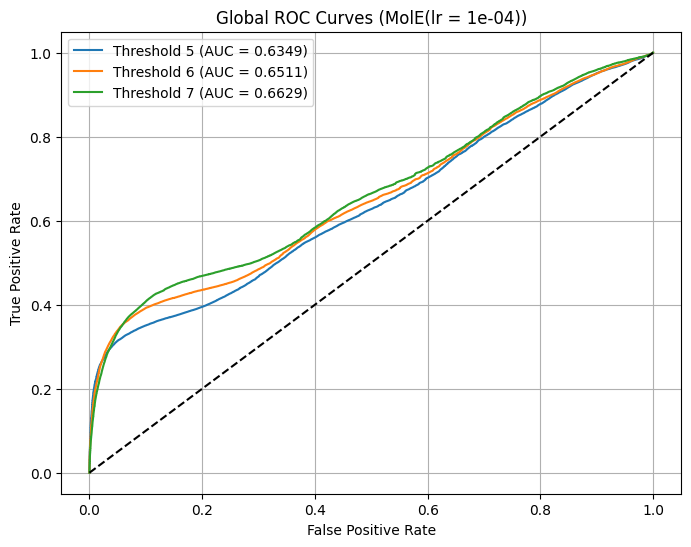

In [13]:
metrics = calculate_global_metric(df00, df2, thresholds=[5,6,7], model_name="MolE(lr = 1e-04)")

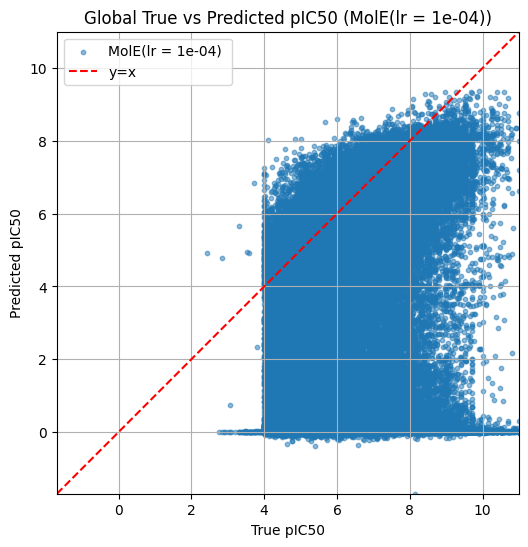

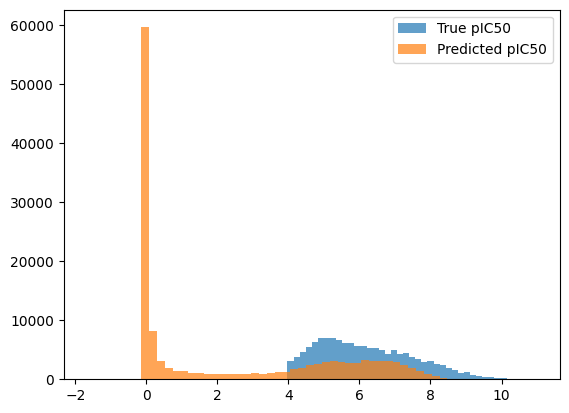

Mean of true values: 6.171844022755179
Mean of predicted values: 2.3829122
Global Metrics (MolE(lr = 1e-04)):
Global MSE (unmasked): 0.006758
Masked MSE (excluding zeros): 21.794939
RMSE (masked): 4.6685
MAE (masked): 3.8917


In [9]:
results2 = calculate_global_regression_metrics(df00, df2, model_name="MolE(lr = 1e-04)")

## 3. Online Random Forest

In [ ]:
df3 = pd.read_parquet('../data/results/predictions_RF_online.parquet')


Results for Threshold = 5 (Random Forest):
Global AUC: 0.5403
Accuracy: 0.2393
Precision: 0.9933
Recall: 0.0170
F1-score: 0.0335
Confusion Matrix:
[[ 30517     12]
 [102659   1778]]

Results for Threshold = 6 (Random Forest):
Global AUC: 0.5452
Accuracy: 0.5145
Precision: 0.9265
Recall: 0.0146
F1-score: 0.0288
Confusion Matrix:
[[68469    77]
 [65450   970]]

Results for Threshold = 7 (Random Forest):
Global AUC: 0.5559
Accuracy: 0.7309
Precision: 0.8801
Recall: 0.0124
F1-score: 0.0244
Confusion Matrix:
[[98194    62]
 [36255   455]]


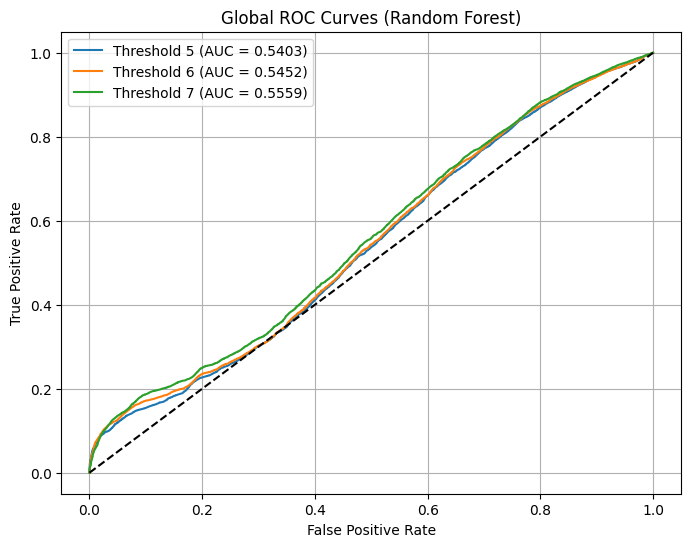

In [11]:
metrics = calculate_global_metric(df00, df3, thresholds=[5,6,7], model_name="Random Forest")

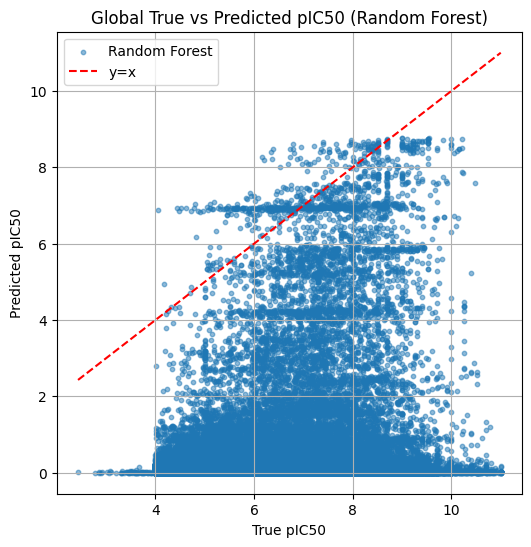

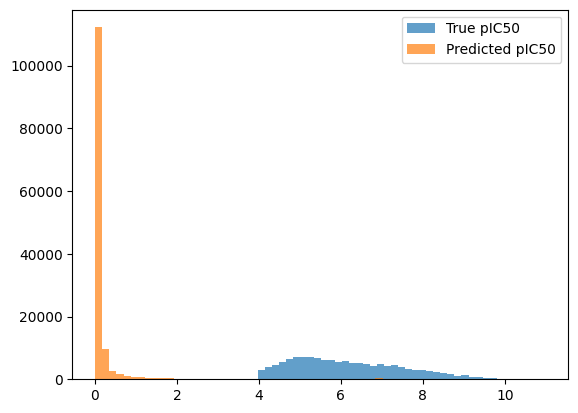

Mean of true values: 6.171844022755179
Mean of predicted values: 0.24566914338815704
Global Metrics (Random Forest):
Global MSE (unmasked): 0.010715
Masked MSE (excluding zeros): 37.299265
RMSE (masked): 6.1073
MAE (masked): 5.9297


In [38]:
results3 = calculate_global_regression_metrics(df00, df3, model_name="Random Forest")

## 4. KNN

In [12]:
df4 = pd.read_parquet('../data/results/predictions_KNN.parquet')


Results for Threshold = 5 (KNN):
Global AUC: 0.7616
Accuracy: 0.6633
Precision: 0.9471
Recall: 0.5983
F1-score: 0.7333
Confusion Matrix:
[[27040  3489]
 [41952 62485]]

Results for Threshold = 6 (KNN):
Global AUC: 0.7924
Accuracy: 0.7727
Precision: 0.8890
Recall: 0.6149
F1-score: 0.7270
Confusion Matrix:
[[63445  5101]
 [25576 40844]]

Results for Threshold = 7 (KNN):
Global AUC: 0.8036
Accuracy: 0.8472
Precision: 0.8102
Recall: 0.5721
F1-score: 0.6707
Confusion Matrix:
[[93335  4921]
 [15707 21003]]


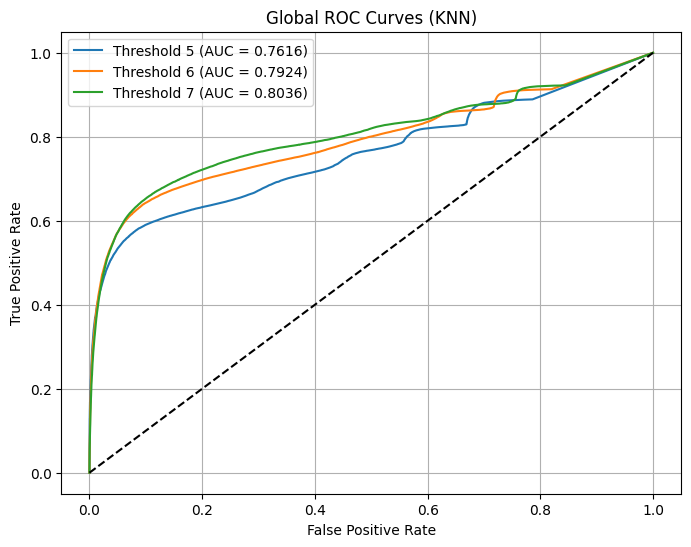

In [26]:
metrics = calculate_global_metric(df00, df4, thresholds=[5,6,7], model_name="KNN")

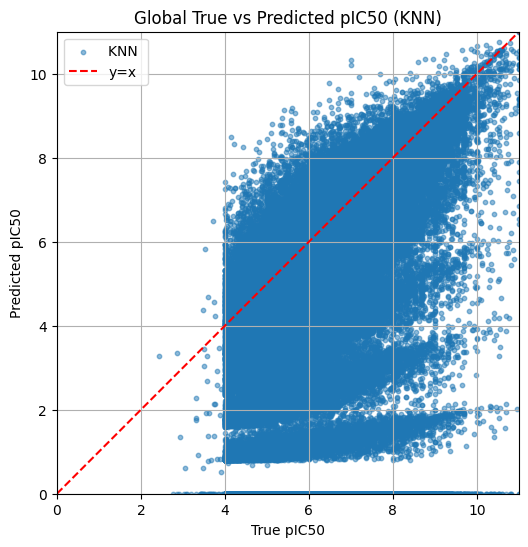

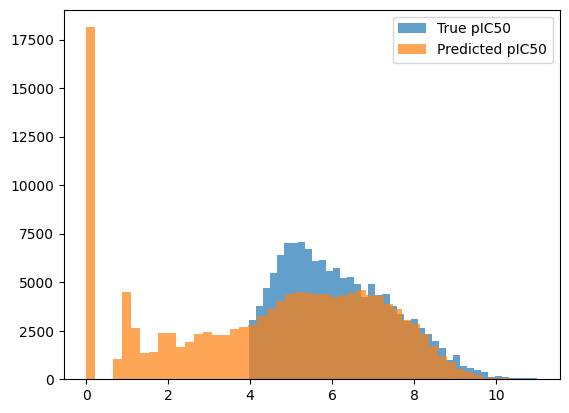

Mean of true values: 6.171844022755179
Mean of predicted values: 4.44645098605523
Global Metrics (KNN):
Global MSE (unmasked): 0.003864
Masked MSE (excluding zeros): 8.136272
RMSE (masked): 2.8524
MAE (masked): 1.9679


In [13]:
results4 = calculate_global_regression_metrics(df00, df4, model_name="KNN")

## 5. XGBoost

In [10]:
df5  =pd.read_parquet("../data/results/prediction_XGB.parquet")


Results for Threshold = 5 (XGBoost(STL)):
Global AUC: 0.7481
Accuracy: 0.5737
Precision: 0.9709
Recall: 0.4630
F1-score: 0.6270
Confusion Matrix:
[[29078  1451]
 [56083 48354]]

Results for Threshold = 6 (XGBoost(STL)):
Global AUC: 0.7771
Accuracy: 0.7262
Precision: 0.9200
Recall: 0.4859
F1-score: 0.6359
Confusion Matrix:
[[65740  2806]
 [34148 32272]]

Results for Threshold = 7 (XGBoost(STL)):
Global AUC: 0.7878
Accuracy: 0.8258
Precision: 0.8460
Recall: 0.4396
F1-score: 0.5786
Confusion Matrix:
[[95319  2937]
 [20573 16137]]


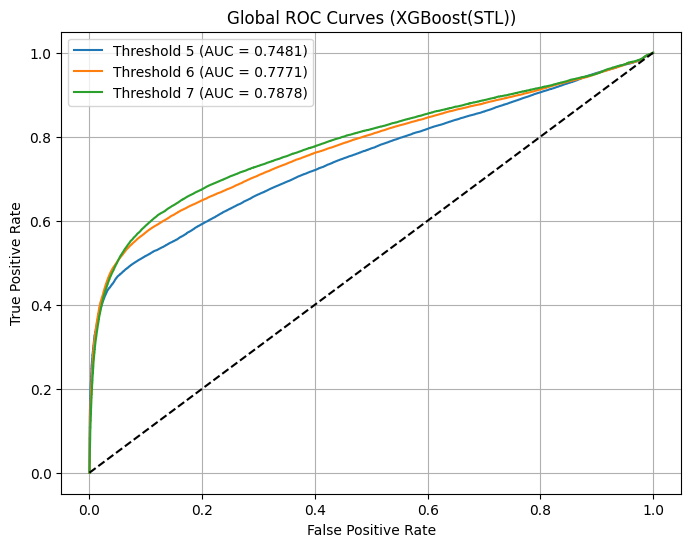

In [28]:
metrics = calculate_global_metric(df00, df5, thresholds=[5,6,7], model_name="XGBoost(STL)")

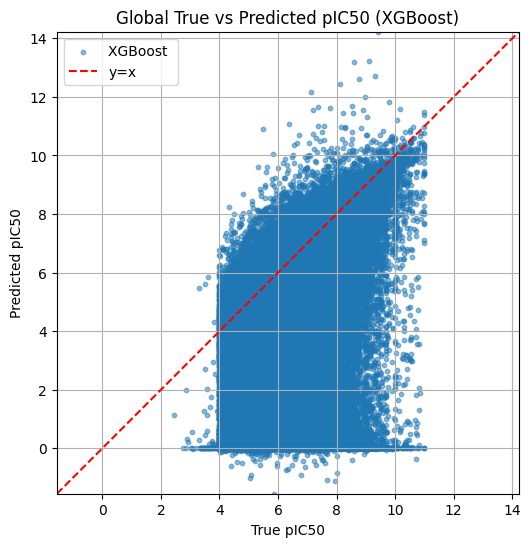

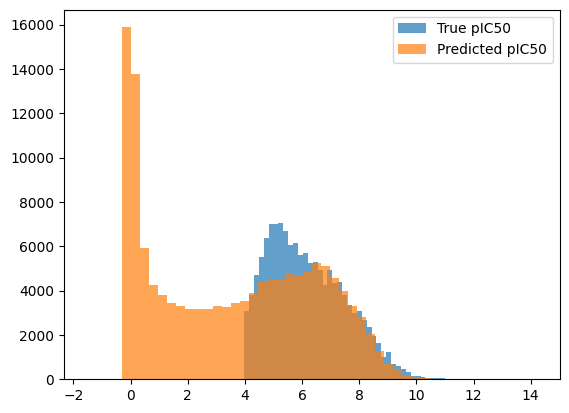

Mean of true values: 6.171844022755179
Mean of predicted values: 3.575013364430806
Global Metrics (XGBoost):
Global MSE (unmasked): 0.004398
Masked MSE (excluding zeros): 12.340501
RMSE (masked): 3.5129
MAE (masked): 2.7356


In [11]:
results5 = calculate_global_regression_metrics(df00, df5, model_name="XGBoost")